In [1]:
# default_exp inferno

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# INFERNO loss

> API details.

In [3]:
#hide
from nbdev.showdoc import *

In [4]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict
from fastcore.all import store_attr
from abc import abstractmethod

import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torch import Tensor
from torch import autograd

# Network

In [5]:
bs = 2000
data, test = get_paper_data(200000, bs=bs, n_test=1000000)

In [6]:
# export
class VariableSoftmax(nn.Softmax):
    def __init__(self, temp:float=1, dim:int=-1):
        super().__init__(dim=dim)
        self.temp = temp
        
    def forward(self, x:Tensor) -> Tensor: return super().forward(x/self.temp)

In [7]:
x = torch.randn((1,10))

In [8]:
VariableSoftmax(0.1)(x), VariableSoftmax(0.5)(x), VariableSoftmax(1)(x)

(tensor([[4.8386e-02, 1.3708e-05, 3.5185e-07, 2.4738e-10, 5.1433e-10, 9.3083e-03,
          5.4147e-06, 9.4226e-01, 2.8601e-05, 2.6392e-06]]),
 tensor([[0.2275, 0.0444, 0.0213, 0.0050, 0.0058, 0.1636, 0.0369, 0.4120, 0.0514,
          0.0319]]),
 tensor([[0.1817, 0.0803, 0.0557, 0.0269, 0.0290, 0.1541, 0.0732, 0.2446, 0.0864,
          0.0681]]))

In [9]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)

# Loss

In [10]:
x,y,w = next(iter(data.trn_dl))
preds = net(x)
assert preds.shape == (bs,10)

In [11]:
def to_shape(p:Tensor) -> Tensor:
    f = p.sum(0)
    f = f/f.sum()
    return f

In [12]:
m = y.squeeze()==0
f_s = to_shape(preds[~m])
f_b = to_shape(preds[m])

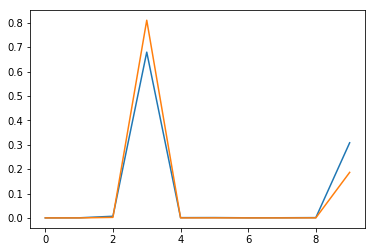

In [13]:
plt.plot(to_np(f_s))
plt.plot(to_np(f_b))

In [14]:
class AbsInferno(AbsCallback):
    def __init__(self, n:int, true_mu:float, n_alphas:int=0, aug_alpha:bool=False):
        super().__init__()
        store_attr()
        self.true_b = self.n-self.true_mu
        
    def on_train_begin(self) -> None:
        self.wrapper.loss_func = None  # Ensure loss function is skipped, callback computes loss value in `on_forwards_end`
        for c in self.wrapper.cbs:
            if hasattr(c, 'loss_is_meaned'): c.loss_is_meaned = False  # Ensure that average losses are correct
        self.alpha = torch.zeros((self.n_alphas+1), requires_grad=True, device=self.wrapper.device)
        with torch.no_grad(): self.alpha[0] = self.true_mu
                
    def on_batch_begin(self) -> None:
        if self.aug_alpha:
            self.rand = torch.randn_like(self.alpha, device=self.wrapper.device)/10
            with torch.no_grad(): self.alpha += self.rand
        self.wrapper.x = self.aug_data(self.wrapper.x)
    
    def on_batch_end(self) -> None:
        if self.aug_alpha:
             with torch.no_grad(): self.alpha -= self.rand
        self.alpha.grad.data.zero_()
    
    @abstractmethod
    def aug_data(self, x:Tensor) -> Tensor: pass
    
    def get_inv_ikk(self, f_s:Tensor, f_b:Tensor) -> Tensor:  
        nll = calc_nll(s_exp=self.alpha[0], alpha=self.alpha[1:], s_true=self.true_mu, b_true=self.true_b,
                       f_s=f_s, f_b_nom=f_b, f_b_up=None, f_b_dw=None)
        _,h = calc_grad_hesse(nll, self.alpha, create_graph=True)
        ikk = torch.inverse(h)[0,0]
#         print(h,ikk)
        return ikk
        
    def on_forwards_end(self) -> None:
        def to_shape(p:Tensor) -> Tensor:
            f = p.sum(0)+1e-7
            return f/f.sum()
        
        b = self.wrapper.y.squeeze() == 0
        f_s = to_shape(self.wrapper.y_pred[~b])
        f_b = to_shape(self.wrapper.y_pred[b])
        self.wrapper.loss_val = self.get_inv_ikk(f_s=f_s, f_b=f_b)

In [15]:
class PaperInferno(AbsInferno):
    def __init__(self, float_r:bool, float_l:bool, l_init:float=3, n:int=1050, true_mu:int=50, aug_alpha:bool=False):
        super().__init__(n=n, true_mu=true_mu, n_alphas=float_r+float_l, aug_alpha=aug_alpha)
        self.float_r,self.float_l,self.l_init = float_r,float_l,l_init
        
    def on_train_begin(self) -> None:
        super().on_train_begin()
#         if self.float_l:
#             with torch.no_grad(): self.alpha[-1] = 1
        
    def aug_data(self, x:Tensor) -> Tuple[Tensor,Tensor]:
        i = 1
        if self.float_r:
            x[:,0] += self.alpha[i]
            i += 1
        if self.float_l:
            x[:,2] *= (self.alpha[i]+self.l_init)/self.l_init
        return x

In [16]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,10), VariableSoftmax(0.1))
init_net(net)
model = ModelWrapper(net)

In [17]:
%%time
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-6), loss=None,
          cbs=[PaperInferno(float_r=1, float_l=0, aug_alpha=False),LossTracker(),SaveBest('weights/best_ie1.h5'),EarlyStopping(10)])

1: Train=429.9869860839844 Valid=372.78731506347657
2: Train=359.68444061279297 Valid=352.8988397216797
3: Train=350.02498901367187 Valid=345.6790783691406
4: Train=343.40363525390626 Valid=340.56659240722655
5: Train=338.45992950439455 Valid=336.59108276367186
6: Train=334.76060974121094 Valid=332.28894287109375
7: Train=331.6452081298828 Valid=329.4747711181641
8: Train=329.03744415283205 Valid=326.2031024169922
9: Train=325.42691711425783 Valid=324.299697265625
10: Train=324.30385925292967 Valid=321.4197216796875
11: Train=322.1323263549805 Valid=319.0329833984375
12: Train=319.92156311035154 Valid=317.0141522216797
13: Train=318.5600308227539 Valid=314.79736389160155
14: Train=316.7531698608398 Valid=313.0703112792969
15: Train=315.097059173584 Valid=311.3639093017578
16: Train=313.5192416381836 Valid=309.6147131347656
17: Train=311.26775817871095 Valid=307.97979248046875
18: Train=310.17436111450195 Valid=306.4327679443359
19: Train=309.3385745239258 Valid=304.4966290283203
20: Tr

155: Train=241.70261322021486 Valid=241.0221405029297
156: Train=241.48189712524413 Valid=240.96077209472656
157: Train=241.0652978515625 Valid=240.90252655029298
158: Train=241.55756790161132 Valid=240.44132873535156
159: Train=241.08077682495116 Valid=240.7944821166992
160: Train=240.41702896118164 Valid=240.73914306640626
161: Train=240.43317932128906 Valid=240.5279769897461
162: Train=241.09737060546874 Valid=240.1882794189453
163: Train=240.4260368347168 Valid=240.46485198974608
164: Train=240.48640548706055 Valid=240.4769674682617
165: Train=240.43069442749024 Valid=239.87660522460936
166: Train=240.67288787841798 Valid=240.56270416259767
167: Train=239.9882389831543 Valid=240.22410858154296
168: Train=239.8876498413086 Valid=240.16143280029297
169: Train=240.29898620605468 Valid=240.16338195800782
170: Train=240.07534530639649 Valid=239.37669921875
171: Train=240.9483477783203 Valid=239.93231536865235
172: Train=240.8013887023926 Valid=239.7138720703125
173: Train=240.3097918701

In [18]:
model.save('weights/Inferno_Test_exact_bm1.h5')

model.load('weights/Inferno_Test_exact_bm1.h5')

# Results

In [19]:
# export
class InfernoPred(PredHandler):
    def get_preds(self) -> np.ndarray: return np.argmax(self.preds, 1)#/len(self.wrapper.model[-2].weight)

## BM 0

In [20]:
preds = model._predict_dl(test, pred_cb=InfernoPred())

In [21]:
df = pd.DataFrame({'pred':preds})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,0,1.0
1,0,1.0
2,7,1.0
3,8,1.0
4,0,1.0


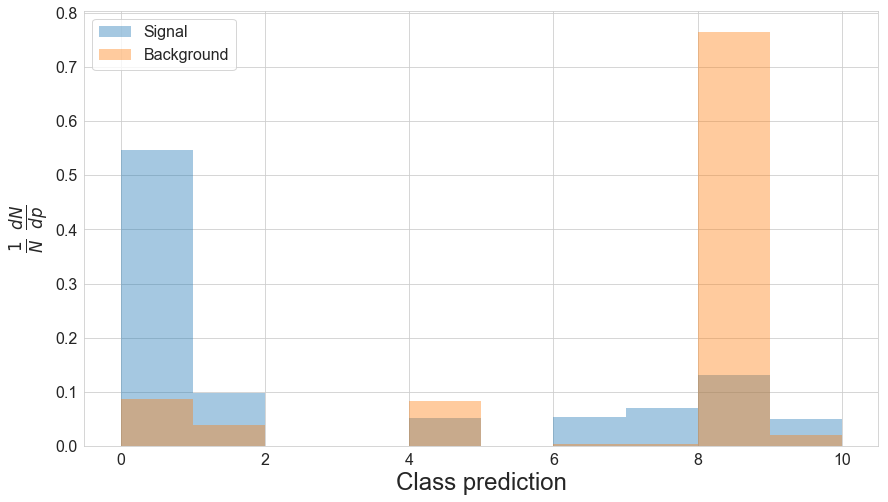

In [22]:
plot_preds(df, bin_edges=np.linspace(0,10,11))

In [23]:
bin_preds(df)

In [24]:
df.head()

,pred,gen_target,pred_bin
0,0,1.0,0
1,0,1.0,0
2,7,1.0,7
3,8,1.0,8
4,0,1.0,0


In [25]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [26]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [27]:
f_s, f_b

(tensor([6.4446e-01, 2.0000e-13, 2.0000e-13, 5.0676e-02, 2.0000e-13, 5.3610e-02,
         7.0642e-02, 1.3155e-01, 4.9062e-02, 2.0000e-13]),
 tensor([1.2619e-01, 2.0000e-13, 2.0000e-13, 8.2064e-02, 2.0000e-13, 3.1420e-03,
         3.7340e-03, 7.6579e-01, 1.9076e-02, 2.0000e-13]))

In [28]:
asimov = (50*f_s)+(1000*f_b)

In [29]:
asimov, asimov.sum()

(tensor([1.5841e+02, 2.1000e-10, 2.1000e-10, 8.4598e+01, 2.1000e-10, 5.8225e+00,
         7.2661e+00, 7.7237e+02, 2.1529e+01, 2.1000e-10]), tensor(1050.))

In [30]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([19.05087471, 18.90958023, 18.77363205, 18.64397049, 18.51986122,
       18.40070915, 18.28798676, 18.18005562, 18.07758713, 17.98022842,
       17.88803864, 17.80079651, 17.7181797 , 17.64143753, 17.56901932,
       17.50190926, 17.43908882, 17.3809185 , 17.3277874 , 17.27875328,
       17.23467255, 17.1946125 , 17.15938187, 17.12848854, 17.10132217,
       17.0789547 , 17.06026268, 17.04661369, 17.03620529, 17.03023911,
       17.02873421, 17.03017426, 17.03653717, 17.04623032, 17.05976868,
       17.07714462, 17.09820175, 17.1234169 , 17.15136719, 17.1842804 ,
       17.21986389, 17.25944138, 17.30219841, 17.34824753, 17.3983078 ,
       17.45121002, 17.50852966, 17.56818771, 17.63156891, 17.69833374,
       17.76771736, 17.84145737, 17.91770935, 17.99669838, 18.07984924,
       18.16504669, 18.25415802, 18.34597015, 18.44075394, 18.53900528,
       18.63929749])

In [31]:
y_tf2 = np.array([31.626238,31.466385,31.313095,31.166267,31.025808,30.891619,30.76361
,30.641693,30.525778,30.415783,30.31162,30.213215,30.120483,30.033348
,29.951736,29.875574,29.804789,29.739307,29.679066,29.623993,29.574026
,29.5291,29.489151,29.454117,29.423939,29.398558,29.377914,29.361954
,29.35062,29.343859,29.341618,29.343842,29.350483,29.36149,29.376812
,29.396404,29.420216,29.448202,29.480318,29.516518,29.556757,29.600994
,29.649185,29.70129,29.757267,29.817076,29.88068,29.948036,30.019108
,30.093859,30.17225,30.25425,30.339819,30.42892,30.521524,30.617598
,30.7171,30.820007,30.926281,31.035892,31.148808], dtype='float32')

In [32]:
y_tf2-y_tf2.min()

array([2.2846203e+00, 2.1247673e+00, 1.9714775e+00, 1.8246498e+00,
       1.6841908e+00, 1.5500011e+00, 1.4219933e+00, 1.3000755e+00,
       1.1841602e+00, 1.0741653e+00, 9.7000313e-01, 8.7159729e-01,
       7.7886581e-01, 6.9173050e-01, 6.1011887e-01, 5.3395653e-01,
       4.6317101e-01, 3.9768982e-01, 3.3744812e-01, 2.8237534e-01,
       2.3240852e-01, 1.8748283e-01, 1.4753342e-01, 1.1249924e-01,
       8.2321167e-02, 5.6940079e-02, 3.6296844e-02, 2.0336151e-02,
       9.0026855e-03, 2.2411346e-03, 0.0000000e+00, 2.2239685e-03,
       8.8653564e-03, 1.9872665e-02, 3.5194397e-02, 5.4786682e-02,
       7.8598022e-02, 1.0658455e-01, 1.3870049e-01, 1.7490005e-01,
       2.1513939e-01, 2.5937653e-01, 3.0756760e-01, 3.5967255e-01,
       4.1564941e-01, 4.7545815e-01, 5.3906250e-01, 6.0641861e-01,
       6.7749023e-01, 7.5224113e-01, 8.3063316e-01, 9.1263199e-01,
       9.9820137e-01, 1.0873032e+00, 1.1799068e+00, 1.2759800e+00,
       1.3754826e+00, 1.4783897e+00, 1.5846634e+00, 1.6942749e

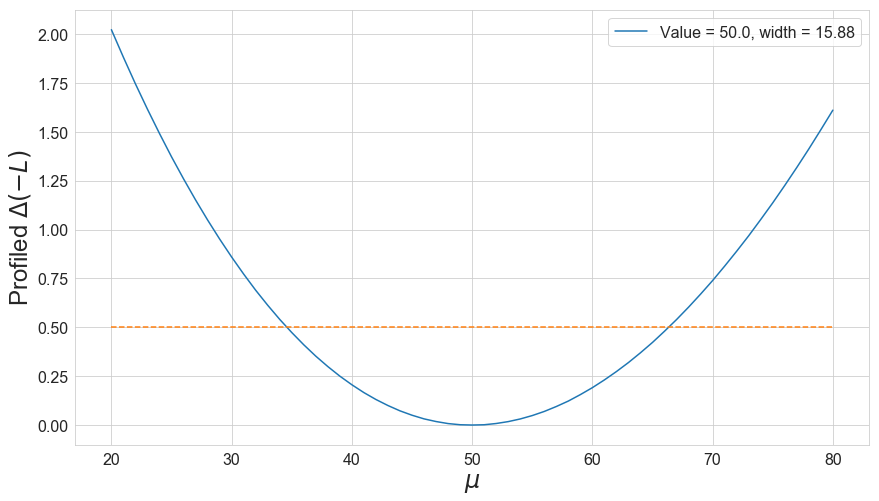

In [33]:
plot_likelihood(y-y.min())

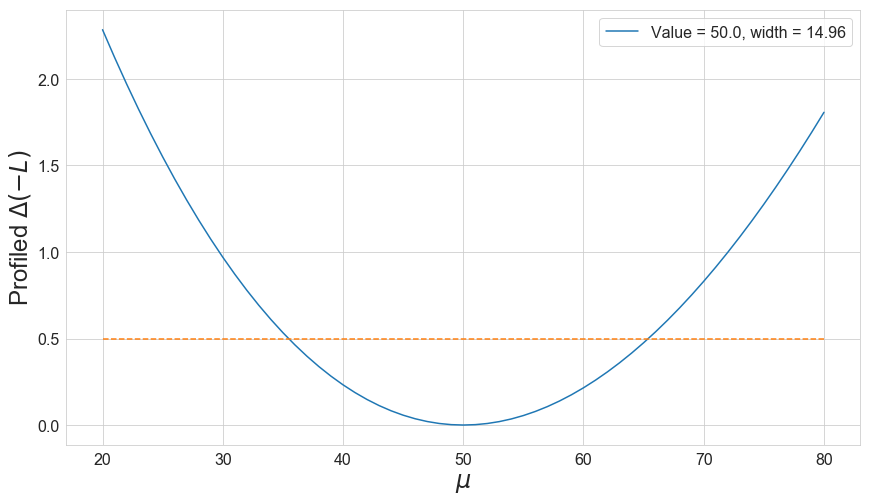

In [34]:
plot_likelihood(y_tf2-y_tf2.min())

# Nuisances - via interpolation

In [35]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [36]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, pred_cb=InfernoPred())

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [37]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,0,1.0,0,0,0,0,0,0,0,0,0,0,0
1,0,1.0,0,0,0,0,0,0,0,0,0,0,0
2,7,1.0,7,7,7,7,7,7,7,7,7,7,7
3,8,1.0,8,8,8,8,8,8,8,8,8,8,8
4,0,1.0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,8,0.0,8,8,8,8,8,8,8,8,8,8,8
999996,8,0.0,8,8,8,8,8,8,8,8,8,8,8
999997,8,0.0,8,8,8,8,8,8,8,8,8,8,8
999998,8,0.0,8,8,8,8,8,8,8,8,8,8,8


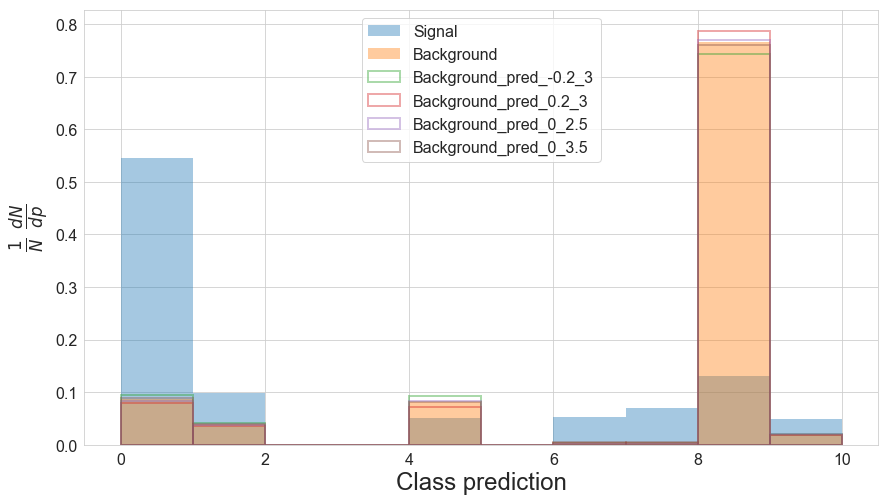

In [38]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'], bin_edges=np.linspace(0,10,11))

tensor([1.3296e-01, 2.0000e-13, 2.0000e-13, 9.3864e-02, 2.0000e-13, 2.0940e-03,
        2.5400e-03, 7.4740e-01, 2.1142e-02, 2.0000e-13])
tensor([1.3705e-01, 2.0000e-13, 2.0000e-13, 9.3152e-02, 2.0000e-13, 3.3680e-03,
        4.0280e-03, 7.4255e-01, 1.9850e-02, 2.0000e-13])
tensor([1.4031e-01, 2.0000e-13, 2.0000e-13, 9.2696e-02, 2.0000e-13, 5.1280e-03,
        5.7160e-03, 7.3738e-01, 1.8766e-02, 2.0000e-13])
tensor([1.2210e-01, 2.0000e-13, 2.0000e-13, 8.2776e-02, 2.0000e-13, 1.8680e-03,
        2.2460e-03, 7.7064e-01, 2.0368e-02, 2.0000e-13])
tensor([1.2619e-01, 2.0000e-13, 2.0000e-13, 8.2064e-02, 2.0000e-13, 3.1420e-03,
        3.7340e-03, 7.6579e-01, 1.9076e-02, 2.0000e-13])
tensor([1.2945e-01, 2.0000e-13, 2.0000e-13, 8.1608e-02, 2.0000e-13, 4.9020e-03,
        5.4220e-03, 7.6062e-01, 1.7992e-02, 2.0000e-13])
tensor([1.1136e-01, 2.0000e-13, 2.0000e-13, 7.3038e-02, 2.0000e-13, 1.6920e-03,
        1.8040e-03, 7.9255e-01, 1.9548e-02, 2.0000e-13])
tensor([1.1546e-01, 2.0000e-13, 2.0000e-1

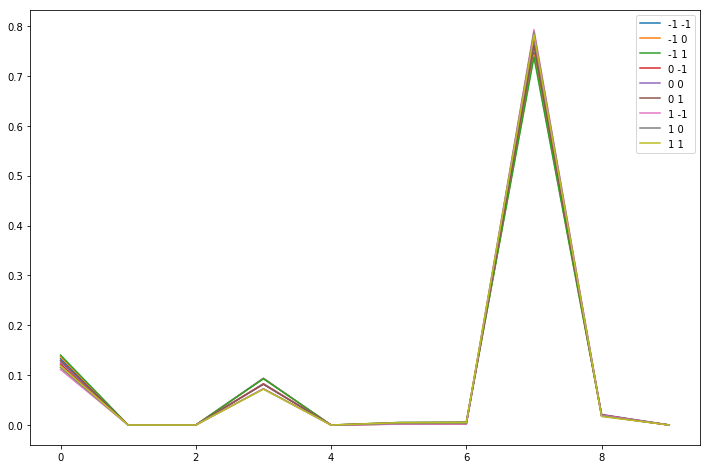

In [39]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        print(s)
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [40]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [41]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [42]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [43]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

In [44]:
nll = to_np(nll)

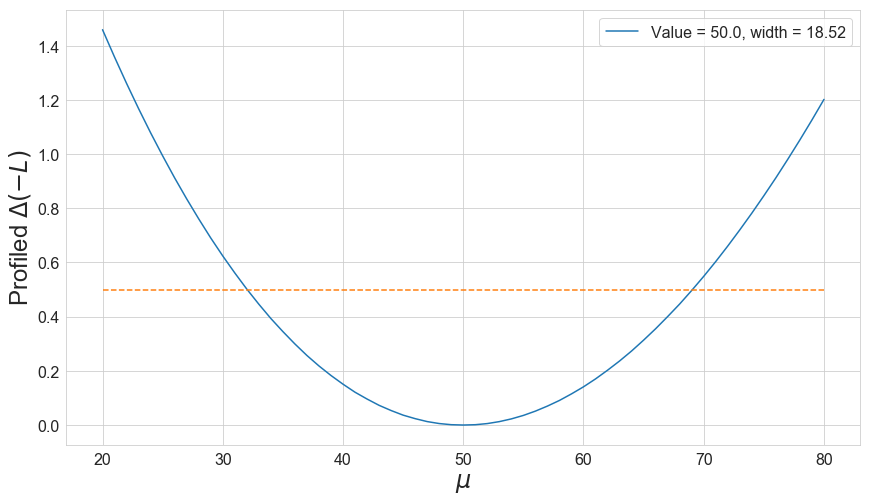

In [45]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [46]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [47]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

Linear regime: Mu 20.0, alpha tensor([1.1933])
Linear regime: Mu 21.0, alpha tensor([1.1528])
Linear regime: Mu 22.0, alpha tensor([1.1123])
Linear regime: Mu 23.0, alpha tensor([1.0718])
Linear regime: Mu 71.0, alpha tensor([-1.0103])
Linear regime: Mu 72.0, alpha tensor([-1.0584])
Linear regime: Mu 73.0, alpha tensor([-1.1064])
Linear regime: Mu 74.0, alpha tensor([-1.1545])
Linear regime: Mu 75.0, alpha tensor([-1.2025])
Linear regime: Mu 76.0, alpha tensor([-1.2505])
Linear regime: Mu 77.0, alpha tensor([-1.2986])
Linear regime: Mu 78.0, alpha tensor([-1.3466])
Linear regime: Mu 79.0, alpha tensor([-1.3946])
Linear regime: Mu 80.0, alpha tensor([-1.4426])


In [48]:
nll = to_np(nll)

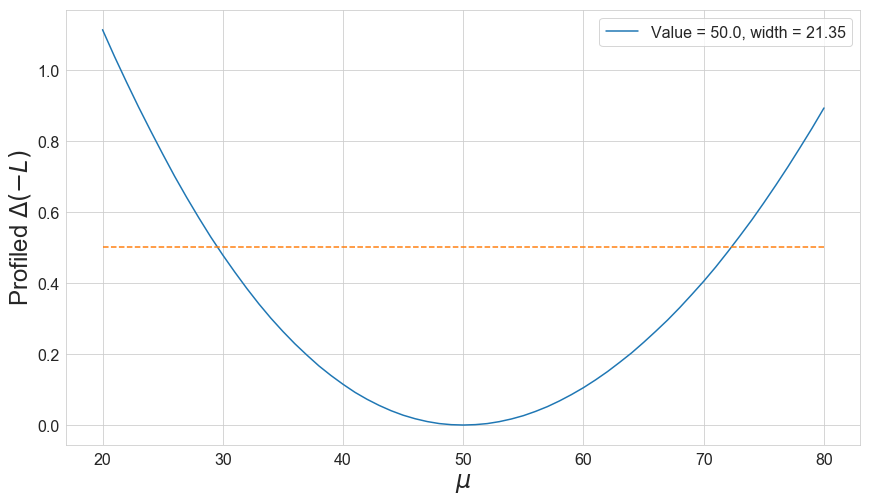

In [49]:
plot_likelihood(nll-nll.min())

## BM 2

In [50]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

Linear regime: Mu 74.0, alpha tensor([ 0.3216, -1.0023])
Linear regime: Mu 75.0, alpha tensor([ 0.3358, -1.0384])
Linear regime: Mu 76.0, alpha tensor([ 0.3492, -1.0801])
Linear regime: Mu 77.0, alpha tensor([ 0.3626, -1.1218])
Linear regime: Mu 78.0, alpha tensor([ 0.3761, -1.1635])
Linear regime: Mu 79.0, alpha tensor([ 0.3895, -1.2053])
Linear regime: Mu 80.0, alpha tensor([ 0.4029, -1.2470])


In [51]:
nll = to_np(nll)

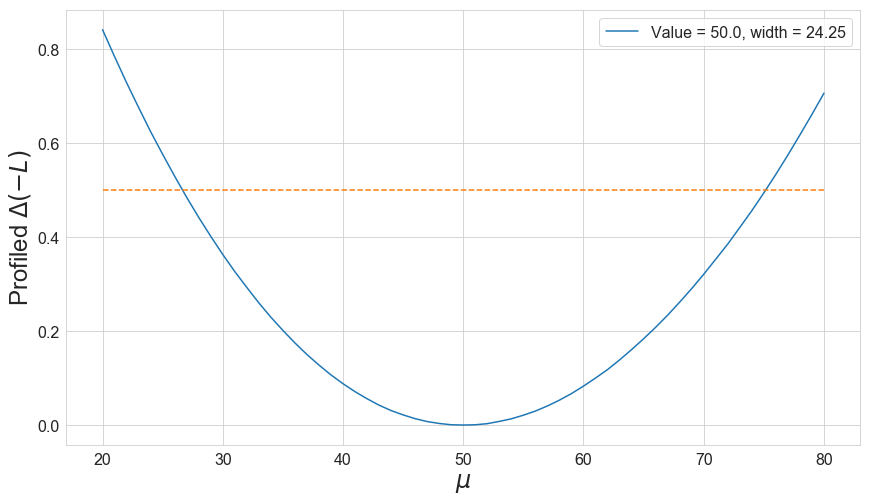

In [52]:
plot_likelihood(nll-nll.min())